In [38]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')

    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)



    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)


def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):

    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]

    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)

    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')

    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])


    return X_train,y_train,X_val,y_val,X_test,y_test

In [39]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.18.0
3.8.0


In [40]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


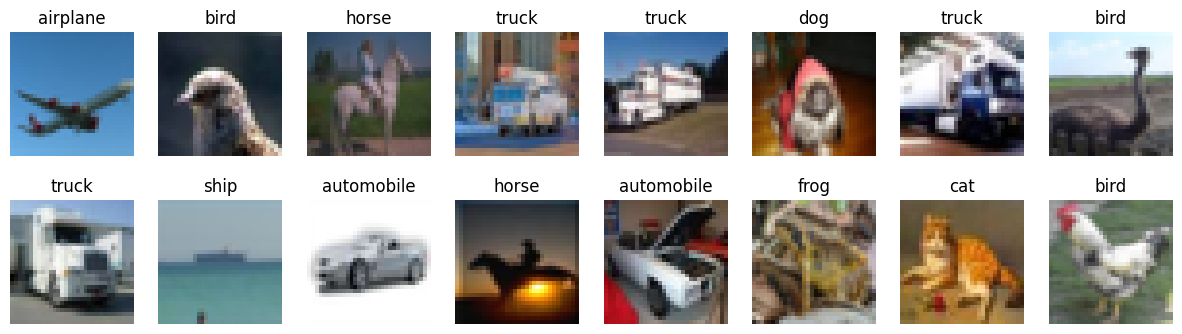

In [41]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [42]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [43]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers import LeakyReLU, BatchNormalization, GlobalAveragePooling2D

In [44]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """

    model = Sequential()

    # first convolutional layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'))
    model.add(BatchNormalization())  # improves stability
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # second convolutional layer
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # third convolutional layer
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # fourth convolutional layer
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # flattening or globalaveragepooling
    model.add(GlobalAveragePooling2D())

    # fully connected layer
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))  # prevents overfitting

    # output layer
    num_classes = 10
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [84]:
from tensorflow.keras.callbacks import EarlyStopping

# check available GPUs for me
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')  # using mixed precision to improve performance

IMG_SIZE = 32  # Input image size
INIT_LR = 5e-4  # Initial learning rate
BATCH_SIZE = 512  # Batch size for training
EPOCHS = 50  # Maximum number of training epochs

K.clear_session()  # clearing previous session to free memory
tf.keras.backend.set_image_data_format('channels_last')  # setting image data format to 'channels_last'

model = make_model()  # creating the model instance

# function to apply data augmentation during training
def preprocess(x, y):
    x = tf.image.random_flip_left_right(x)  # Randomly flip images horizontally
    x = tf.image.random_brightness(x, max_delta=0.2)  # Random brightness adjustment
    x = tf.image.random_contrast(x, 0.8, 1.2)  # Random contrast adjustment

    x = tf.image.random_crop(x, [IMG_SIZE - 4, IMG_SIZE - 4, 3])  # Random cropping
    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE))  # Resizing back to target size

    x = tf.image.random_jpeg_quality(x, 75, 100)  # Random JPEG quality adjustment

    return tf.cast(x, tf.float16), y  # Convert image to float16 for mixed precision training

# creating the training dataset with preprocessing and performance optimizations
train_dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)  # apply preprocessing in parallel
    .shuffle(20000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)  # prefetch data for better pipeline performance
)

# define optimizer with weight decay for better generalization
optimizer = keras.optimizers.AdamW(learning_rate=INIT_LR, weight_decay=1e-4)

# define callbacks for training
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)  # Stop early if validation accuracy does not improve
]

# compile the model with categorical crossentropy loss and label smoothing
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=optimizer,
    metrics=['accuracy']
)

tf.config.optimizer.set_jit(True)  # enable XLA for performance improvement

# train the model with training dataset and validation data
model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=callbacks  # apply early stopping if necessary
)

# save the model weights for later use
model.save_weights("myweights.weights.h5")


# takes around 6-7 min to finish, accuracy around 76-78%

Num GPUs Available:  1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.2688 - loss: 2.2257 - val_accuracy: 0.0966 - val_loss: 2.5785
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.4552 - loss: 1.6941 - val_accuracy: 0.1164 - val_loss: 2.7331
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.5235 - loss: 1.5609 - val_accuracy: 0.2549 - val_loss: 2.7159
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.5689 - loss: 1.4762 - val_accuracy: 0.2329 - val_loss: 2.6625
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.5977 - loss: 1.4243 - val_accuracy: 0.3480 - val_loss: 2.0236
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.6218 - loss: 1.3716 - val_accuracy: 0.5061 - val_loss: 1.6293
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.6398 - loss: 1.3285 - val_accuracy: 0.6216 - val_loss: 1.3637
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.6661 - loss: 1.2852 - val_accuracy: 0.668

In [85]:
# load weights from file (can call without model.fit)
model.load_weights("myweights.weights.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


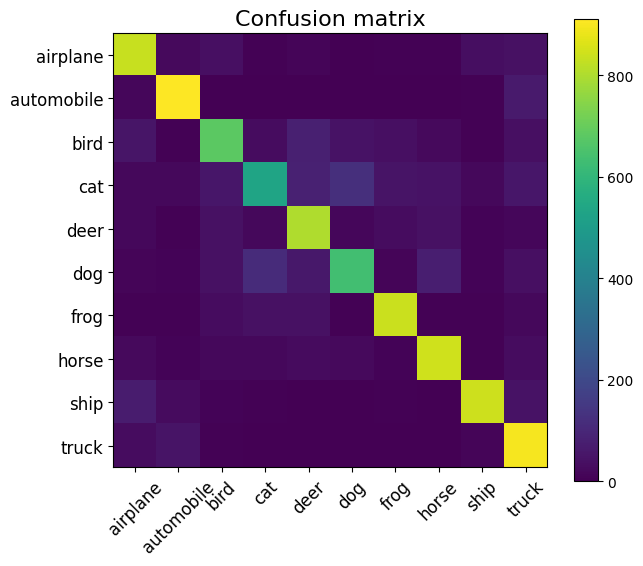

Test accuracy: 0.7808


In [86]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

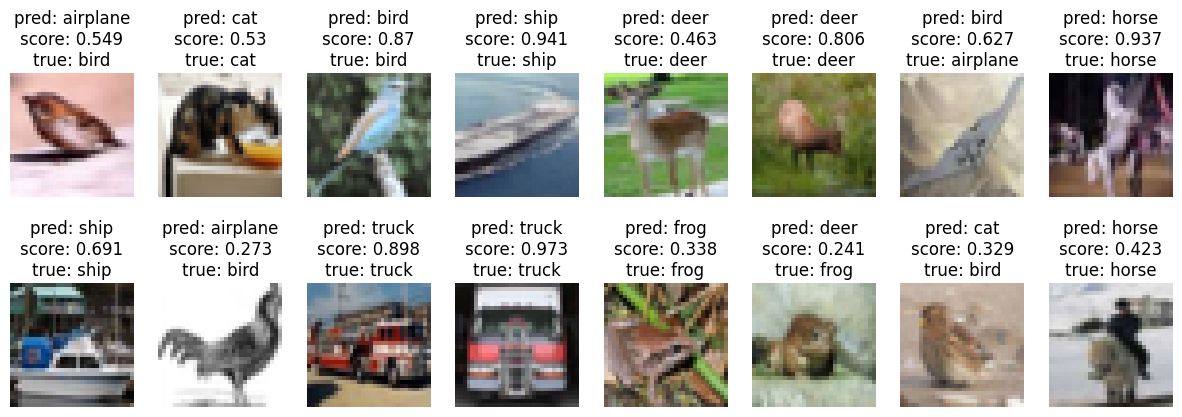

In [87]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

**Iteration Path Report**

### **1. Initial Model Overview:**
The first code was a basic CNN model with the following:
- The output layer used a softmax activation function for multi-class classification.
- Training was performed using:
  - **Optimizer:** Adamax
  - **Loss Function:** Categorical Crossentropy
  - **Batch Size:** 32
  - **Epochs:** 1
  - **Learning Rate:** 5e-3
  
### **2. what was missing:**
- Lack of defined convolutional layers, reducing the model’s ability to extract features.
- No batch normalization, which could stabilize and accelerate training.
- No dropout layers, increasing the risk of overfitting.
- Small batch size and low epochs, leading to suboptimal learning.
- Use of Adamax instead of modern optimizers like AdamW.
- No data augmentation, which could improve generalization.

---
### **3. Improvements:**

#### **3.1 Architectural Enhancements**
- **Added four convolutional layers**:
  - First Layer: 32 filters, 3x3 kernel, ReLU activation, batch normalization, max pooling.
  - Second Layer: 64 filters, same configuration.
  - Third Layer: 128 filters, same configuration.
  - Fourth Layer: 256 filters (added for deeper feature extraction).
- **Global Average Pooling** instead of Flattening to reduce parameters and improve efficiency.
- **Fully connected (Dense) layer with 256 neurons** for higher-level feature representation.
- **Dropout (0.5) added** to prevent overfitting.

#### **3.2 Training Optimizations**
- **Improved optimizer:** Switched from Adamax to **AdamW** with weight decay for better convergence.
- **Batch size increased** from 32 to 512 to stabilize gradients and leverage GPU efficiency.
- **Increased epochs** from 1 to 50 for better learning.
- **Lowered initial learning rate** from **5e-3 to 5e-4** to prevent aggressive updates.
- **Enabled label smoothing (0.1)** to improve generalization by reducing overconfidence.
- **Early stopping added** (patience = 7) to prevent overfitting.
- **Enabled XLA compilation (JIT)** to accelerate model training.

#### **3.3 Data Augmentation**
- Applied transformations to increase dataset variability:
  - **Random flips** (horizontal flips for more diversity)
  - **Random brightness & contrast adjustments** to account for lighting variations.
  - **Random cropping & resizing** for spatial transformations.
  - **JPEG quality adjustments** to simulate real-world compression artifacts.

---
### **4. Expected Benefits of Improvements:**
| Improvement | Expected Benefit |
|------------|-----------------|
| Deeper CNN with BatchNorm | Better feature extraction and stable gradients |
| Global Average Pooling | Reduces overfitting and improves generalization |
| Dropout (0.5) | Prevents overfitting |
| AdamW Optimizer | Faster convergence, better weight regularization |
| Larger batch size (512) | Better gradient estimation, optimized for GPUs |
| Lower Learning Rate | More stable training, prevents overshooting |
| Label Smoothing | Reduces model overconfidence, improves calibration |
| Early Stopping | Prevents overfitting by stopping at optimal epoch |
| Data Augmentation | Enhances model to real-world variations |

---
### **5. Conclusion:**
The new model enhances feature extraction, regularization, and training stability. These improvements are expected to result in higher accuracy(between 76-78%), better generalization, and reduced overfitting. The addition of data augmentation, AdamW optimizer, and improved hyperparameters gives a more effective CNN for classification tasks.

